In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

output_path = '/home/FRACTAL/shaheen.perveen/stage3/model_outputs/'

import os
os.chdir('/home/FRACTAL/shaheen.perveen/fastai/old')
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from pathlib import *
import pandas as pd
import numpy as np

#checking wheteher cuda and cudnn are available. Cuda is necessary & Cudnn is optional, it makes computation faster
#using  device 1-gpu
torch.cuda.set_device(1)
torch.cuda.is_available()

torch.backends.cudnn.enabled

True

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

output_path = '/home/FRACTAL/shaheen.perveen/stage3/model_outputs/'

import os
os.chdir('/home/FRACTAL/shaheen.perveen/fastai/old')
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from pathlib import *
import pandas as pd
import numpy as np

#checking wheteher cuda and cudnn are available. Cuda is necessary & Cudnn is optional, it makes computation faster
torch.cuda.is_available()

torch.backends.cudnn.enabled

#using  device 0-gpu
torch.cuda.set_device(1)
torch.cuda.current_device()



#checking the data
input_path = '/home/FRACTAL/shaheen.perveen/stage3/fakers/stage-3/stage3_image_data/train_ela/'
# classes = pd.read_csv(input_path+'train_label.csv',header=None)
# classes.rename(columns={0:'label_id',2:'class',1:'to_drop'},inplace=True)
# classes.drop('to_drop',inplace=True,axis=1)

# labels = pd.read_csv(input_path+'scene_labels.csv')
# labels.drop('Unnamed: 0',inplace=True,axis=1)

# labels['label_id'] = labels['label_id'].astype(str)
# classes['label_id']= classes['label_id'].astype(str)

# labels = labels.merge(classes,how='left')
# labels = labels[~labels['class'].isna()]
# labels.reset_index(drop=True,inplace=True)

# labels_model = labels[['image_id','class']]
labels_model = pd.read_csv(input_path+'label_ela.csv')

labels_model.head()
print(labels_model.shape)

labels = labels_model[['class']]
labels.head()

labels['class'] = np.where(labels['class'] == 'real',1,0)
labels.head()

labels.describe()

def get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header,augmentation_required):
    if (augmentation_required):
        tfms = tfms_from_model(f_model, sz,aug_tfms=aug_tfms,max_zoom=1.1)
    else:
        tfms =  tfms_from_model(f_model, sz)
    
    label_csv.to_csv(str(root_path)+'temp_label_file.csv',index=False)
    
    return ImageClassifierData.from_csv(root_path, train_folder,str(root_path)+'temp_label_file.csv',bs=bs,tfms=tfms,
                     val_idxs=val_idxs,test_name=test_folder,skip_header=skip_header)

def exp_name(output_path,freeze,model_name,lrn,sz):
    return output_path+freeze+'_'+'_'+model_name+'_lr'+str(lrn)+'_sz'+str(sz)

label_csv = labels_model.copy()
#a root path of the data (used for storing trained models, precomputed values, etc)
root_path=('/home/FRACTAL/shaheen.perveen/stage3/temp_root/')
#a name of the folder in which training images are contained.
train_folder = ('')
#a name of the folder which contains test images.
test_folder= ('/home/FRACTAL/shaheen.perveen/stage3/fakers/stage-3/stage3_image_data/test/test')

#for generating the validation indexes
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1729)
labels_splits = labels.copy()
X= labels['class'].astype(int)
y=labels['class'].astype(int)

for train_index, test_index in sss.split(X, y):
    trn_indx = train_index
    val_idxs = test_index

f_model=resnext101_64
sz=224
aug_tfms=None
max_zoom=None
bs=4
#use this if we dont need augmentation
augmentation_required = False

model_name=str(f_model).split(' ')[1]

(32259, 2)


/home/FRACTAL/shaheen.perveen/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)

In [4]:
learn = ConvLearner.pretrained(f_model, data,precompute=False)

 64%|██████▍   | 4124/6452 [04:05<02:01, 19.21it/s, loss=2.14] 

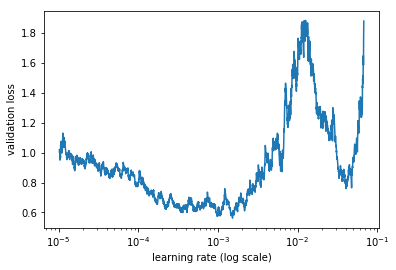

In [5]:
lrf=learn.lr_find()

learn.sched.plot()

In [6]:
lrn=1e-4

In [7]:
learn.fit(lrn, 3, cycle_len=1, cycle_mult=2)


learn.save(exp_name(output_path,'frz_postH',model_name,lrn,sz))

#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz_postH',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
learn.save(exp_name(output_path,'unfrz_postH',model_name,lrn,sz))


epoch      trn_loss   val_loss   accuracy                      
    0      0.586695   0.529149   0.743025  
    1      0.515653   0.517954   0.74814                        
    2      0.554545   0.518899   0.74597                       
    3      0.51796    0.5163     0.746435                      
    4      0.547421   0.512371   0.752015                      
    5      0.536661   0.511265   0.75062                       
    6      0.515583   0.510629   0.749535                      


epoch      trn_loss   val_loss   accuracy                      
    0      0.527096   0.493871   0.761004  
    1      0.464122   0.476146   0.771389                      
    2      0.44549    0.468788   0.773404                      


In [9]:
sz
# lrn

224

 40%|███▉      | 2556/6452 [10:33<15:15,  4.26it/s, loss=0.979]

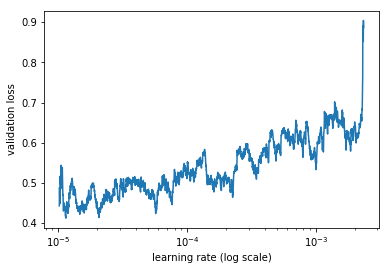

In [10]:
lrf=learn.lr_find()

learn.sched.plot()

In [11]:
#
learn.load(exp_name(output_path,'unfrz_postH',model_name,lrn,sz))
learn.freeze()

sz=400
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)
learn.set_data(data)



lrn=3e-5

learn.fit(lrn, 3, cycle_len=1, cycle_mult=2)

learn.save(exp_name(output_path,'frz_postH',model_name,lrn,sz))

#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz_postH',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
learn.save(exp_name(output_path,'unfrz_postH',model_name,lrn,sz))


epoch      trn_loss   val_loss   accuracy                      
    0      0.492143   0.461121   0.779448  
    1      0.445194   0.458218   0.780533                      
    2      0.514942   0.457808   0.780378                       
    3      0.454509   0.456177   0.781773                      
    4      0.466678   0.455259   0.781773                      
    5      0.454716   0.455074   0.781618                      
    6      0.455185   0.454975   0.782083                       


epoch      trn_loss   val_loss   accuracy                      
    0      0.430591   0.450653   0.786268  
    1      0.432704   0.445567   0.789523                       
    2      0.473096   0.44294    0.790608                       


In [12]:
#
learn.load(exp_name(output_path,'unfrz_postH',model_name,lrn,sz))
learn.freeze()

sz=512
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)
learn.set_data(data)



lrn=3e-4

learn.fit(lrn, 3, cycle_len=1, cycle_mult=2)

learn.save(exp_name(output_path,'frz_postH',model_name,lrn,sz))

#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz_postH',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
learn.save(exp_name(output_path,'unfrz_postH',model_name,lrn,sz))

epoch      trn_loss   val_loss   accuracy                      
    0      0.418746   0.444044   0.793862  
    1      0.420505   0.445874   0.795102                      
    2      0.433694   0.437814   0.797427                      
    3      0.499305   0.439868   0.793397                       
    4      0.440029   0.431567   0.799752                      
    5      0.445338   0.429156   0.802387                      
    6      0.367692   0.428476   0.804557                      


  0%|          | 0/6452 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [5]:
lrn=3e-4
sz=512

In [7]:
exp_name(output_path,'frz_postH',model_name,lrn,sz)

'/home/FRACTAL/shaheen.perveen/stage3/model_outputs/frz_postH__resnext101_64_lr0.0003_sz512'

In [8]:
#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz_postH',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
learn.save(exp_name(output_path,'unfrz_postH',model_name,lrn,sz))

epoch      trn_loss   val_loss   accuracy                      
    0      0.411814   0.442312   0.793087  
    1      0.408912   0.467746   0.780998                      
    2      0.400221   0.429889   0.804092                       

